# Milestone 2

---

Milestones ini dibuat guna mengevaluasi pembelajaran pada Hacktiv8 Data Science Full Time Program Phase 2 khususnya pada Deep Learning.

## Introduction

By [Rifky Aliffa](https://github.com/Penzragon)

![Image](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a6/The_Rim_Fire_in_the_Stanislaus_National_Forest_near_in_California_began_on_Aug._17%2C_2013-0004.jpg/1200px-The_Rim_Fire_in_the_Stanislaus_National_Forest_near_in_California_began_on_Aug._17%2C_2013-0004.jpg)

### Dataset

Pada project ini dataset yang digunakan adalah berbagai macam gambar kebakaran dan api. Dataset dapat dilihat di [Kaggle](https://www.kaggle.com/datasets/phylake1337/fire-dataset).

### Objectives

**Milestones 2** ini dibuat guna mengevaluasi Pembelajaran Phase 2 :

- Mampu memahami konsep Computer Vision/NLP.
- Mampu mempersiapkan data untuk digunakan dalam model Computer Vision/NLP.
- Mampu mengimplementasikan Artificial Neural Network dengan data yang ada.
- Mampu menganalisis dan menjelaskan layer yang dibuat.

Dan tujuan utama dari project ini adalah untuk membuat model CNN yang mampu mendeteksi apakah terjadi kebakaran atau tidak.

## Import Libraries

Pada project ini library yang akan digunakan adalah **Pandas**, **Numpy**, **Matplotlib**, **Seaborn**, **Tensorflow**, **Keras**, dan **Scikit-Learn**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Loading

Membuat dataframe yang berisi path dari gambar berikut labelnya.

In [3]:
# Create an empty dataframe
fire = pd.DataFrame(columns=['image', 'label'])

# Loop through fire_images directory and add each image and label to the dataframe
for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/fire_images'):
    for filename in filenames:
        fire = fire.append({'image': os.path.join(dirpath, filename), 'label': 'fire'}, ignore_index=True)

# Loop through non_fire_images directory and add each image and label to the dataframe
for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/non_fire_images'):
    for filename in filenames:
        fire = fire.append({'image': os.path.join(dirpath, filename), 'label': 'non_fire'}, ignore_index=True)
        
# Shuffle the dataframe
fire = fire.sample(frac=1).reset_index(drop=True)

In [4]:
fire.head(20)

,image,label
0,dataset/fire_dataset/non_fire_images\non_fire....,non_fire
1,dataset/fire_dataset/fire_images\fire.142.png,fire
2,dataset/fire_dataset/fire_images\fire.612.png,fire
3,dataset/fire_dataset/non_fire_images\non_fire....,non_fire
4,dataset/fire_dataset/fire_images\fire.325.png,fire
5,dataset/fire_dataset/fire_images\fire.696.png,fire
6,dataset/fire_dataset/fire_images\fire.737.png,fire
7,dataset/fire_dataset/fire_images\fire.479.png,fire
8,dataset/fire_dataset/fire_images\fire.720.png,fire
9,dataset/fire_dataset/fire_images\fire.639.png,fire


In [5]:
fire.shape

(999, 2)

Data ini berisi **999 gambar** dengan 2 label yaitu **fire** dan **non_fire**.

## Exploratory Data Analysis (EDA)

### Label

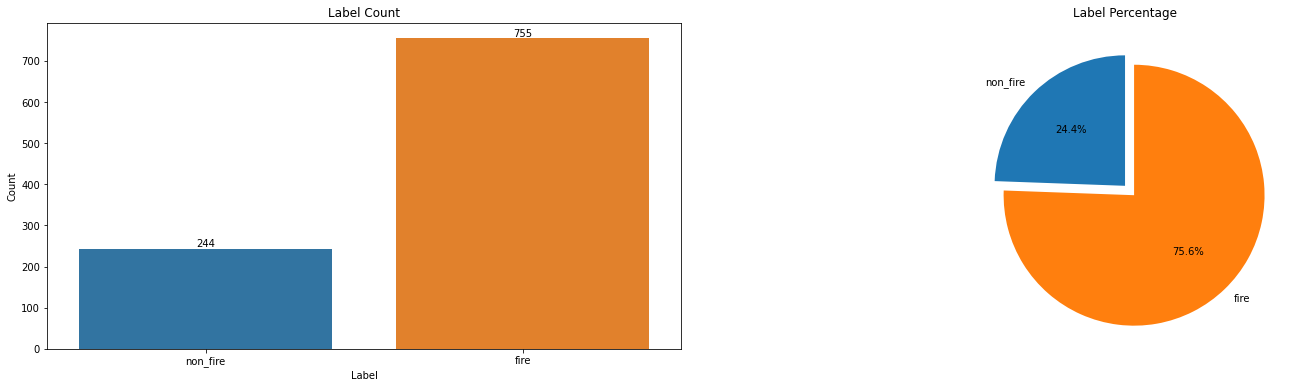

In [17]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
fig = sns.countplot(x='label', data=fire)
for p in fig.patches:
    height = p.get_height()
    fig.text(p.get_x() + p.get_width()/2., height + 0.5, height, ha='center', va='bottom')
plt.title('Label Count')
plt.xlabel('Label')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.pie(fire['label'].value_counts().reindex(['non_fire', 'fire']), labels=fire.label.value_counts().reindex(['non_fire', 'fire']).index, autopct='%1.1f%%', startangle=90, explode=(0, 0.1))
plt.title('Label Percentage')
plt.show()

Pada dataset terdapat **label imbalanced** dimana jumlah gambar berlabel non_fire lebih sedikit dibandingkan gambar berlabel fire yaitu hanya **244 gambar** atau sekitar **24%** gambar saja yang memiliki label non_fire.